# EJERCICIOS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import min, max, avg, countDistinct, col, row_number,collect_list,unix_timestamp, from_unixtime, month, year, split, to_timestamp, udf,sum as _sum, hour
from pyspark.sql.window import Window
from pyspark.sql.types import StructType,StructField,StringType,IntegerType,FloatType,DoubleType,TimestampType
import seaborn as sns


In [2]:
spark = SparkSession.builder.master("local[*]").appName("pyspark_dataframes2").getOrCreate()
#spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

25/02/10 15:24:55 WARN Utils: Your hostname, iadb-12 resolves to a loopback address: 127.0.1.1; using 172.20.104.44 instead (on interface wlp44s0f0)
25/02/10 15:24:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/10 15:24:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


25/02/10 15:25:07 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


## EJERCICIO 0
En un documento word haz una lista de las diferentes operaciones con una breve descripción de lo que hace y un ejemplo de como se utiliza

## EJERCICIO 1
Realiza las siguientes operaciones:
* Carga el dataset de “data/stocks_price_final.csv” (usa el esquema que creaste en la anterior relación de ejercicios)
* Calcula el mínimo y máximo de date, open, close y adjusted
* Calcula la media de las variables open, close y adjusted por industria
* Genera un gráfico de líneas donde se muestre la media de open por industria para los 25 primeros registros
* Guarda en un archivo json una selección de datos

In [7]:
esquema = StructType([
    StructField("", IntegerType(), False),
    StructField("symbol", StringType(), False),
    StructField("date", StringType(), False),
    StructField("open", FloatType(), False),
    StructField("high", FloatType(), False),
    StructField("low", FloatType(), False),
    StructField("close", FloatType(), False),
    StructField("volume", IntegerType(), False),
    StructField("adjusted", FloatType(), False),
    StructField("market.cap", StringType(), False),
    StructField("sector", StringType(), False),
    StructField("industry", StringType(), False),
    StructField("exchange", StringType(), False)
])
dfStock = spark.read.option("header", True).schema(esquema).csv("Datos/stocks_price_final.csv")
dfStock.show()

+---+------+----------+-----+------+------+-----+-------+--------+----------+-------------+--------------------+--------+
|   |symbol|      date| open|  high|   low|close| volume|adjusted|market.cap|       sector|            industry|exchange|
+---+------+----------+-----+------+------+-----+-------+--------+----------+-------------+--------------------+--------+
|  1|   TXG|2019-09-12| 54.0|  58.0|  51.0|52.75|7326300|   52.75|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  2|   TXG|2019-09-13|52.75|54.355| 49.15|52.27|1025200|   52.27|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  3|   TXG|2019-09-16|52.45|  56.0| 52.01| 55.2| 269900|    55.2|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  4|   TXG|2019-09-17|56.21|  60.9|55.423|56.78| 602800|   56.78|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  5|   TXG|2019-09-18|56.85| 62.27| 55.65| 62.0|1589600|    62.0|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  6|   TXG|2019-09-19|6

In [8]:
dfStock.select(min("date"), max("date"), min("open"), max("open"), min("close"), max("close"), min("adjusted"), max("adjusted")).show()

+----------+----------+---------+-----------+----------+-----------+-------------+-------------+
| min(date)| max(date)|min(open)|  max(open)|min(close)| max(close)|min(adjusted)|max(adjusted)|
+----------+----------+---------+-----------+----------+-----------+-------------+-------------+
|2019-01-02|2020-07-22|    0.072|1.6016818E8|     0.071|1.5837659E8|    -1.230099|  1.5724939E8|
+----------+----------+---------+-----------+----------+-----------+-------------+-------------+



In [11]:
dfStock.groupBy("industry").agg(avg("open"), avg("close"), avg("adjusted")).show()

+--------------------+------------------+------------------+------------------+
|            industry|         avg(open)|        avg(close)|     avg(adjusted)|
+--------------------+------------------+------------------+------------------+
|Finance/Investors...| 5.134401791443934|  5.13663074735324| 4.991354066764518|
|Biotechnology: Bi...| 24.80808319217773| 24.80358715006997| 24.74507997837481|
|Other Specialty S...| 84.80718810495605| 84.80276551199054| 84.55525036659287|
|Other Consumer Se...| 43.67010744364806| 43.65868871111973| 43.43498980900172|
|        Water Supply| 40.58048307729203|40.584873748260975|  40.1733279180834|
|               Banks| 21.44122961212158| 21.44016833129883|21.029210063934325|
|Farming/Seeds/Mil...|27.740143444537836| 27.74297949601548| 27.02253924121552|
|Medical/Nursing S...| 71.03728952381898| 71.09947780813135| 70.77964411635287|
|Biotechnology: La...|102.15234117212717|102.28519780657979|102.24022549038418|
| Television Services|119.26427651404161

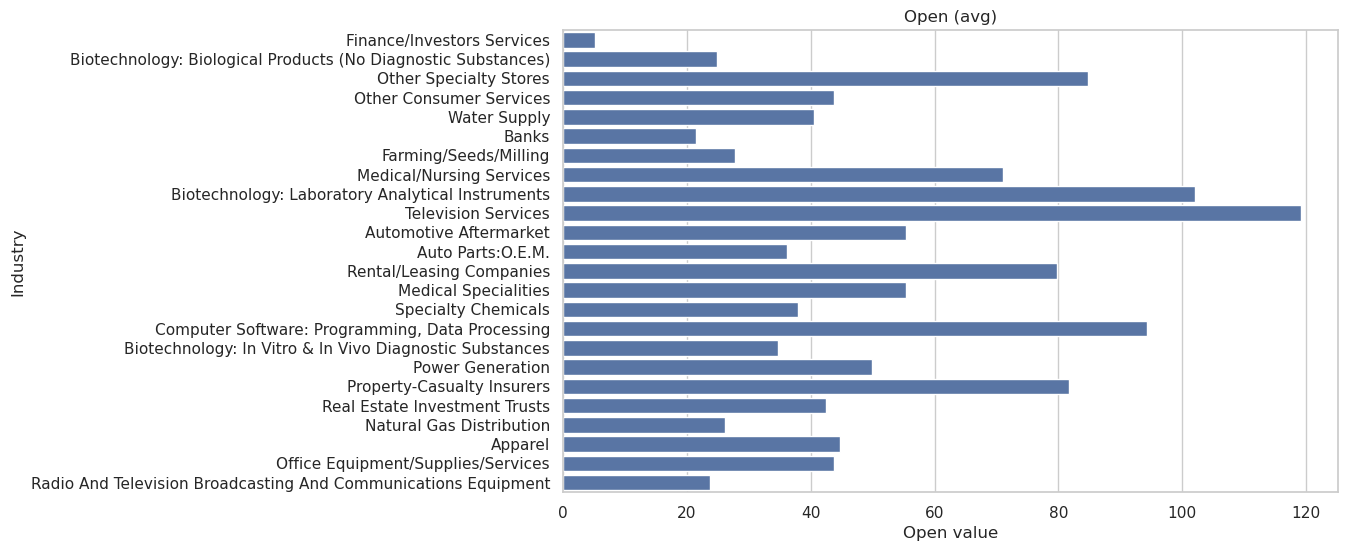

In [ ]:
pdData = dfStock.groupBy("industry").agg(avg("open")).limit(24).toPandas() # El 25 es major chemicals y vale tanto que no proyecta correctamente el resto de valores

plt.figure(figsize=(10, 6))
plt.ticklabel_format(useOffset=False, style="plain")
sns.set_theme(style="whitegrid")
sns.barplot(x="avg(open)", y="industry", data=pdData).set_title("Open (avg)")
plt.xlabel("Open value")
plt.ylabel("Industry")

plt.show()

In [15]:
dfStock.groupBy("industry").agg(avg("open")).limit(24).write.json("Datos/open_avg_per_industry_top_24.json")

## EJERCICIO 2

 Sobre las movies.tsv (importa el tsv sin esquema, pero añade los nombres de la columnas al cargar el tsv):

1. ¿Cuantas películas diferentes hay? Usando sql y sin usar sql.
2. ¿En cuantas películas ha trabajado Murphy, Eddie (I)? Usando sql y sin usar sql.
3. ¿Cuáles son los actores que han aparecido en más de 30 películas? Usando sql y sin usar sql.
4. ¿En que película anterior a 1980 aparecen al menos 25 intérpretes? Usando sql y sin usar sql.
5. Muestra la cantidad de películas producidas cada año (solo debe mostrar el año y la cantidad), ordenando el listado por la cantidad de forma descendente. Usando sql y sin usar sql.
6. A partir de la consulta anterior, crea un gráfico de barras que muestre el año y la cantidad de películas, ordenados por fecha.

In [19]:
dfMovies = spark.read.option("header", False).csv("Datos/movies.tsv", sep="\t")
dfMovies = dfMovies.toDF("interprete", "pelicula", "anyo")
dfMovies.createOrReplaceTempView("movies")
resultSQL = spark.sql("SELECT COUNT(DISTINCT pelicula) AS num_peliculas FROM movies")
resultSQL.show()
print(dfMovies.select("pelicula").distinct().count())

+-------------+
|num_peliculas|
+-------------+
|         1409|
+-------------+

1409


In [25]:
resultSQL = spark.sql("SELECT COUNT(DISTINCT pelicula) AS num_peliculas FROM movies WHERE interprete = 'Murphy, Eddie (I)'")
resultSQL.show()
print(dfMovies.filter(dfMovies["interprete"] == "Murphy, Eddie (I)").count())

+-------------+
|num_peliculas|
+-------------+
|           21|
+-------------+

21


In [29]:
resultSQL = spark.sql("SELECT interprete, COUNT(DISTINCT pelicula) AS num_peliculas FROM movies GROUP BY interprete HAVING COUNT(DISTINCT pelicula) > 30")
resultSQL.show()
dfMovies.groupBy("interprete").agg(countDistinct("pelicula").alias("num_peliculas")).filter("num_peliculas > 30").show()

+------------------+-------------+
|        interprete|num_peliculas|
+------------------+-------------+
|     Harnell, Jess|           31|
|  Tatasciore, Fred|           38|
|Jackson, Samuel L.|           32|
|     Welker, Frank|           38|
+------------------+-------------+

+------------------+-------------+
|        interprete|num_peliculas|
+------------------+-------------+
|     Harnell, Jess|           31|
|  Tatasciore, Fred|           38|
|Jackson, Samuel L.|           32|
|     Welker, Frank|           38|
+------------------+-------------+



In [32]:
resultSQL = spark.sql("SELECT pelicula, COUNT(DISTINCT interprete) AS num_interpretes FROM movies WHERE anyo < 1980 GROUP BY pelicula HAVING COUNT(DISTINCT interprete) >= 25")
resultSQL.show()
dfMovies.filter(dfMovies["anyo"] < 1980).groupBy("pelicula").agg(countDistinct("interprete").alias("num_interpretes")).filter("num_interpretes >= 25").show()

+---------+---------------+
| pelicula|num_interpretes|
+---------+---------------+
|Star Wars|             25|
+---------+---------------+

+---------+---------------+
| pelicula|num_interpretes|
+---------+---------------+
|Star Wars|             25|
+---------+---------------+



In [38]:
resultSQL = spark.sql("SELECT anyo, COUNT(DISTINCT pelicula) AS num_peliculas FROM movies GROUP BY anyo ORDER BY num_peliculas DESC")
resultSQL.show()
dfMovies.groupBy("anyo").agg(countDistinct("pelicula").alias("num_peliculas")).orderBy("num_peliculas", ascending=False).show()

+----+-------------+
|anyo|num_peliculas|
+----+-------------+
|2006|           86|
|2004|           86|
|2011|           86|
|2005|           85|
|2008|           82|
|2002|           81|
|2010|           78|
|2000|           77|
|2003|           76|
|2007|           75|
|2001|           71|
|2009|           68|
|1999|           67|
|1997|           66|
|1998|           59|
|1996|           42|
|2012|           32|
|1995|           25|
|1994|           16|
|1986|           16|
+----+-------------+
only showing top 20 rows

+----+-------------+
|anyo|num_peliculas|
+----+-------------+
|2006|           86|
|2004|           86|
|2011|           86|
|2005|           85|
|2008|           82|
|2002|           81|
|2010|           78|
|2000|           77|
|2003|           76|
|2007|           75|
|2001|           71|
|2009|           68|
|1999|           67|
|1997|           66|
|1998|           59|
|1996|           42|
|2012|           32|
|1995|           25|
|1994|           16|
|1986|  

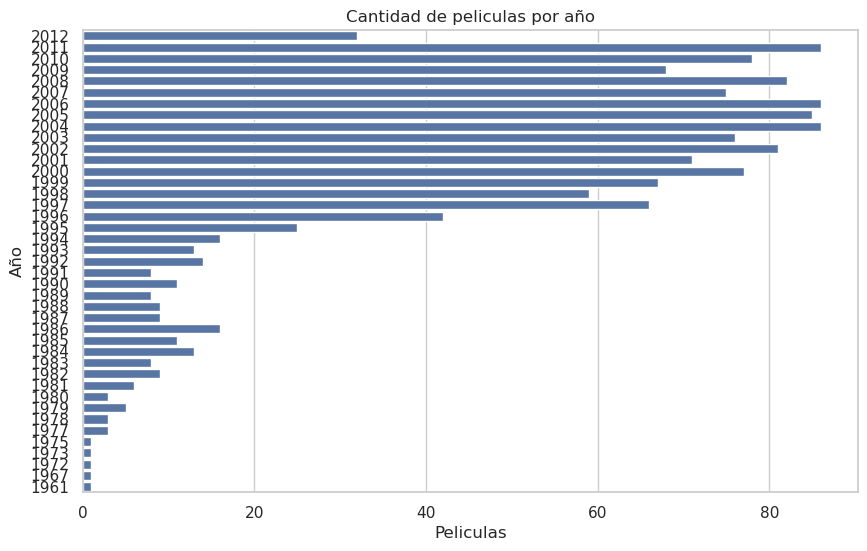

In [42]:
pdData = dfMovies.groupBy("anyo").agg(countDistinct("pelicula").alias("num_peliculas")).orderBy("anyo", ascending=False).toPandas()

plt.figure(figsize=(10, 6))
plt.ticklabel_format(useOffset=False, style="plain")
sns.set_theme(style="whitegrid")
sns.barplot(x="num_peliculas", y="anyo", data=pdData).set_title("Cantidad de peliculas por año")
plt.xlabel("Peliculas")
plt.ylabel("Año")

plt.show()

## EJERCICIO 3

Nos han enviado un nuevo archivo llamado movie-ratings.tsv que contiene las calificaciones de las películas.

1. Crea un DataFrame que contenga los datos de ambos datasets. Usando sql y sin usar sql
2. Muestra para cada año, la película con mayor puntuación (año, título de la película, puntuación). Investiga que es Window Functions en Spark y utilizalas para devolver lo que se pide.
3. Sobre los datos anteriores, obtén también una lista con los nombres de los intérpretes. 
4. Averigua las tres parejas de intérpretes han trabajado juntos en más ocasiones. La salida debe tener tres columnas: interprete1, interprete2 y cantidad (necesitas utilizar un self-join).

## EJERCICIO 4

Hemos recibido un dataset con las ventas de 2019 de una tienda americana de productos de tecnología, mediante un conjunto de ficheros en formato CSV comprimidos en salesdata.zip.

1. Una vez descomprimidos los datos, crea un DataFrame con todos los datos, infiriendo el esquema.
2. Vuelve a realizar la lectura de los datos pero con el siguiente esquema:

    ``````
    from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
    esquema = StructType([
        StructField("Order ID", IntegerType(), False),
        StructField("Product", StringType(), False),
        StructField("Quantity Ordered", IntegerType(), True),
        StructField("Price Each", DoubleType(), False),
        StructField("Order Date", StringType(), False),
        StructField("Purchase Address", StringType(), False)
    ])
    ``````
3. Tras la lectura, vamos a realizar la limpieza de datos. El primer paso será renombrar la columnas para eliminar los espacios en blanco.
4. Elimina las filas que contengan algún campo nulo.
5. Comprueba si las cabeceras de los archivos aparecen como datos del dataset (por ejemplo, un producto cuyo nombre sea Product). Si fuera el caso, elimina dichas filas.
6. A partir del campo dirección, crea dos nuevas columnas para almacenar la ciudad (City) y el estado (State). Por ejemplo, para la dirección 136 Church St, New York City, NY 10001, la ciudad es New York City y el estado es NY.
7. Modifica el campo con la fecha del pedido para que su formato sea timestamp.
8. Sobre el campo anterior, crea dos nuevas columnas, con el mes (Month) y el año (Year) del pedido.
9. Crea una nueva columan (precio_final) muestre el precio con descuento: un 10% de descuento si la cantidad es mayor que 1 y un 5% si es uno (hazlo definiendo tu propia función de usuario). Hazlo sin sql y con sql.

### 1

In [33]:
dfSalesRaw = spark.read.csv("Datos/salesdata/*.csv", header=True)
dfSalesRaw.show(1)
dfSalesRaw.printSchema()

+--------+------------------+----------------+----------+--------------+--------------------+
|Order ID|           Product|Quantity Ordered|Price Each|    Order Date|    Purchase Address|
+--------+------------------+----------------+----------+--------------+--------------------+
|  295665|Macbook Pro Laptop|               1|      1700|12/30/19 00:01|136 Church St, Ne...|
+--------+------------------+----------------+----------+--------------+--------------------+
only showing top 1 row

root
 |-- Order ID: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Quantity Ordered: string (nullable = true)
 |-- Price Each: string (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Purchase Address: string (nullable = true)



### 2

In [34]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

esquema = StructType([
    StructField("Order ID", IntegerType(), False),
    StructField("Product", StringType(), False),
    StructField("Quantity Ordered", IntegerType(), True),
    StructField("Price Each", DoubleType(), False),
    StructField("Order Date", StringType(), False),
    StructField("Purchase Address", StringType(), False)
])

dfSales = spark.read.csv("Datos/salesdata/*.csv", schema=esquema, header=True)
dfSales.show(1)
dfSales.printSchema()

+--------+------------------+----------------+----------+--------------+--------------------+
|Order ID|           Product|Quantity Ordered|Price Each|    Order Date|    Purchase Address|
+--------+------------------+----------------+----------+--------------+--------------------+
|  295665|Macbook Pro Laptop|               1|    1700.0|12/30/19 00:01|136 Church St, Ne...|
+--------+------------------+----------------+----------+--------------+--------------------+
only showing top 1 row

root
 |-- Order ID: integer (nullable = true)
 |-- Product: string (nullable = true)
 |-- Quantity Ordered: integer (nullable = true)
 |-- Price Each: double (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Purchase Address: string (nullable = true)



### 3

In [35]:
dfSales = dfSales.select([col(c).alias(c.replace(" ", "_")) for c in dfSales.columns]) # Por cada columna crea un alias donde todo " " sea "_"
dfSales.show(1)

+--------+------------------+----------------+----------+--------------+--------------------+
|Order_ID|           Product|Quantity_Ordered|Price_Each|    Order_Date|    Purchase_Address|
+--------+------------------+----------------+----------+--------------+--------------------+
|  295665|Macbook Pro Laptop|               1|    1700.0|12/30/19 00:01|136 Church St, Ne...|
+--------+------------------+----------------+----------+--------------+--------------------+
only showing top 1 row



### 4

In [36]:
print(dfSales.count())
dfSales = dfSales.dropna("any") # Elimina toda fila con cualquier nº elementos NULL > 1
print(dfSales.count())

186850
185950


### 5

In [37]:
dfSales.filter(dfSales.Product == "Product").count() # No se han cogido las cabeceras por el Header = True de la carga

0

### 6

In [38]:
from pyspark.sql.functions import split

dfSales = dfSales.withColumn("City", split(dfSales["Purchase_Address"], ", ")[1]).withColumn("State", split(dfSales["Purchase_Address"], ", ")[2].substr(1, 2))
dfSales.show(5)

+--------+--------------------+----------------+----------+--------------+--------------------+-------------+-----+
|Order_ID|             Product|Quantity_Ordered|Price_Each|    Order_Date|    Purchase_Address|         City|State|
+--------+--------------------+----------------+----------+--------------+--------------------+-------------+-----+
|  295665|  Macbook Pro Laptop|               1|    1700.0|12/30/19 00:01|136 Church St, Ne...|New York City|   NY|
|  295666|  LG Washing Machine|               1|     600.0|12/29/19 07:03|562 2nd St, New Y...|New York City|   NY|
|  295667|USB-C Charging Cable|               1|     11.95|12/12/19 18:21|277 Main St, New ...|New York City|   NY|
|  295668|    27in FHD Monitor|               1|    149.99|12/22/19 15:13|410 6th St, San F...|San Francisco|   CA|
|  295669|USB-C Charging Cable|               1|     11.95|12/18/19 12:38|43 Hill St, Atlan...|      Atlanta|   GA|
+--------+--------------------+----------------+----------+-------------

### 7

In [39]:
from pyspark.sql.functions import to_timestamp

dfSales = dfSales.withColumn("Order_Date", to_timestamp(dfSales["Order_Date"], "MM/dd/yy HH:mm"))
dfSales.printSchema()
dfSales.show(5)

root
 |-- Order_ID: integer (nullable = true)
 |-- Product: string (nullable = true)
 |-- Quantity_Ordered: integer (nullable = true)
 |-- Price_Each: double (nullable = true)
 |-- Order_Date: timestamp (nullable = true)
 |-- Purchase_Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)

+--------+--------------------+----------------+----------+-------------------+--------------------+-------------+-----+
|Order_ID|             Product|Quantity_Ordered|Price_Each|         Order_Date|    Purchase_Address|         City|State|
+--------+--------------------+----------------+----------+-------------------+--------------------+-------------+-----+
|  295665|  Macbook Pro Laptop|               1|    1700.0|2019-12-30 00:01:00|136 Church St, Ne...|New York City|   NY|
|  295666|  LG Washing Machine|               1|     600.0|2019-12-29 07:03:00|562 2nd St, New Y...|New York City|   NY|
|  295667|USB-C Charging Cable|               1|    

### 8

In [41]:
from pyspark.sql.functions import month, year

dfSales = dfSales.withColumn("Month", month(dfSales["order_date"])).withColumn("Year", year(dfSales["order_date"]))
dfSales.show(5)


+--------+--------------------+----------------+----------+-------------------+--------------------+-------------+-----+-----+----+
|Order_ID|             Product|Quantity_Ordered|Price_Each|         Order_Date|    Purchase_Address|         City|State|Month|Year|
+--------+--------------------+----------------+----------+-------------------+--------------------+-------------+-----+-----+----+
|  295665|  Macbook Pro Laptop|               1|    1700.0|2019-12-30 00:01:00|136 Church St, Ne...|New York City|   NY|   12|2019|
|  295666|  LG Washing Machine|               1|     600.0|2019-12-29 07:03:00|562 2nd St, New Y...|New York City|   NY|   12|2019|
|  295667|USB-C Charging Cable|               1|     11.95|2019-12-12 18:21:00|277 Main St, New ...|New York City|   NY|   12|2019|
|  295668|    27in FHD Monitor|               1|    149.99|2019-12-22 15:13:00|410 6th St, San F...|San Francisco|   CA|   12|2019|
|  295669|USB-C Charging Cable|               1|     11.95|2019-12-18 12:38:

### 9

In [43]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# Clonar el dfSales para usar luego SQL
dfSales2 = dfSales.select("*")

# Definir la UDF
def aplicar_descuento(price, quantity):
    if quantity > 1:
        return price * 0.90
    else:
        return price * 0.95
calcular_precio_udf = udf(aplicar_descuento, DoubleType())

# Aplicar la UDF
dfSales2 = dfSales2.withColumn("precio_final", calcular_precio_udf(dfSales2["Price_Each"], dfSales2["Quantity_Ordered"]))
dfSales2.select("Price_Each", "Quantity_Ordered", "precio_final").show(10)


+----------+----------------+------------------+
|Price_Each|Quantity_Ordered|      precio_final|
+----------+----------------+------------------+
|    1700.0|               1|            1615.0|
|     600.0|               1|             570.0|
|     11.95|               1|           11.3525|
|    149.99|               1|          142.4905|
|     11.95|               1|           11.3525|
|      3.84|               1|3.6479999999999997|
|     11.95|               1|           11.3525|
|     11.95|               2|10.754999999999999|
|     99.99|               1|           94.9905|
|      2.99|               4|2.6910000000000003|
+----------+----------------+------------------+
only showing top 10 rows



In [44]:
# Crear view para aplicar SQL a la tabla temporal "sales"
dfSales.createOrReplaceTempView("sales")

# Consulta SQL
dfSalesSQL = spark.sql("SELECT *,CASE WHEN Quantity_Ordered > 1 THEN Price_Each * 0.90 ELSE Price_Each * 0.95 END AS precio_final FROM sales")

# Mostrar resultados
dfSalesSQL.select("Price_Each", "Quantity_Ordered", "precio_final").show(10)


+----------+----------------+------------------+
|Price_Each|Quantity_Ordered|      precio_final|
+----------+----------------+------------------+
|    1700.0|               1|            1615.0|
|     600.0|               1|             570.0|
|     11.95|               1|           11.3525|
|    149.99|               1|          142.4905|
|     11.95|               1|           11.3525|
|      3.84|               1|3.6479999999999997|
|     11.95|               1|           11.3525|
|     11.95|               2|10.754999999999999|
|     99.99|               1|           94.9905|
|      2.99|               4|2.6910000000000003|
+----------+----------------+------------------+
only showing top 10 rows



## EJERCICIO 5

Una vez realizada la transformación de los datos, vamos a realizar su carga y extraer información, utilizando Spark SQL siempre que sea posible:

1. Almacena los datos en formato Parquet en la carpeta salesoutput particionando los datos por año y mes. Tras ejecutar esta operación, comprueba en disco la estructura de archivos creada.
2. Sobre los datos almacenados, realiza una nueva lectura pero solo leyendo los datos de 2019 los cuales deberían estar almacenados en ./salesdataoutput/Year=2019.
3. Averigua cual ha sido el mes que ha recaudado más. Para ello, deberás multiplicar el precio por la cantidad de unidades, y posteriormente, realizar alguna agregación. Sobre el resultado, crea un gráfico de barras verticales para representar las ventas totales por mes
4. Obtén un gráfico de barras horizontales con las 10 ciudades que más unidades han vendido (ordenadas, la más larga arriba)
5. Obtén un gráfico de línea que represente la cantidad de pedidos por Horas en las que se ha realizado un pedido que contenía al menos dos productos.